In [5]:
import yfinance as yf
from typing import List
from pandas_datareader import data as pdr
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from docopt import docopt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown, display
import plotly.express as px
"""
Usage: analyse_data.py –company=<company> –start=<start> -end=<end>
"""
args = docopt(doc=__doc__, argv=None, help=True,
              version=None, options_first=False)
 
# Supress warning in hmmlearn
warnings.filterwarnings("ignore")
# Change plot style to ggplot (for better and more aesthetic visualisation)
plt.style.use('ggplot')

yf.pdr_override()


# if __name__ == "__main__":
#     start, end = "2021-01-01", "2021-03-01"
#     print(get_financial_time_series("GME", start, end, ['Open', 'High', 'Low', 'Close']))
#     GME_stock = get_financial_time_series("GME", start, end, ['Open', 'High', 'Low', 'Close'])

DocoptExit: Usage: analyse_data.py –company=<company> –start=<start> -end=<end>

D:\Anaconda3\envs\CS5340\lib\site-packages\IPython\core\interactiveshell.py:3333: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
def get_financial_time_series(symbol: str, start_date: str, end_date: str,
                              type: List[str] = ('Date','Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','LIBOR')):
    return pdr.get_data_yahoo(symbol, start=start_date, end=end_date)[type]
 
class StockPredictor(object):
    def __init__(self, company,start, end, n_latency_days=10,
                 n_hidden_states=4,n_steps_frac_change=50,
                 n_steps_frac_high=10,n_steps_frac_low=10, 
                 test_size=0.2, ):
        self._init_logger()
 
        self.company = company
        self.n_latency_days = n_latency_days
        self.start = start
        self.end = end
        self.data = get_financial_time_series(company, start, end, ['Open', 'High', 'Low', 'Close']).reset_index()
        
        self.hmm = GaussianHMM(n_components=n_hidden_states)
        self._split_train_test_data(test_size)
        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)
 
 
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
 
 
    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['Open'])
        close_price = np.array(data['Close'])
        high_price = np.array(data['High'])
        low_price = np.array(data['Low'])
 
        # Compute the fraction change in close, high and low prices
        # which would be used a feature
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price
 
        return np.column_stack((frac_change, frac_high, frac_low))

    def _split_train_test_data(self, test_size):
        _train_data, test_data = train_test_split(
            self.data, test_size=test_size, shuffle=False)
 
        self._train_data = _train_data
        self._test_data = test_data
        
    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vector = StockPredictor._extract_features(self.data)
        self._logger.info('Features extraction Completed <<<')
 
        self.hmm.fit(feature_vector)
    
    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
 
        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))
    
    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = StockPredictor._extract_features(
            previous_data)
 
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
 
        return most_probable_outcome

    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['Open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(day_index)
        return open_price * (1 + predicted_frac_change)
    
    
    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_close_prices = []
        for day_index in tqdm(range(days)):
            predicted_close_prices.append(self.predict_close_price(day_index))
 
        if with_plot:
            test_data = self._test_data[0: days]
            days = np.array(test_data['Date'], dtype="datetime64[ms]")
            actual_close_prices = test_data['Close']
 
            fig = plt.figure(figsize=(16,8))
 
            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'bo-', label="actual")
            axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
            axes.set_title('{company}'.format(company=self.company))
 
            fig.autofmt_xdate()
 
            plt.legend()
            plt.show()
 
        return predicted_close_prices
    
# Predictor for GME stocks
start, end = "2019-01-01", "2021-03-25"
stock_predictor = StockPredictor(company='GME',start=start, end=end)

In [7]:
stock_predictor.data['Date'] = pd.to_datetime(stock_predictor.data['Date'])
stock_predictor.data.head()

,Date,Open,High,Low,Close
0,2018-12-31,12.33,12.67,12.31,12.62
1,2019-01-02,12.45,13.18,12.42,13.07
2,2019-01-03,12.98,13.26,12.69,12.97
3,2019-01-04,14.03,15.29,13.70,15.24
4,2019-01-07,15.11,15.81,14.94,15.48


In [8]:
stock_predictor.data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

In [9]:
stock_predictor.fit()

2021-03-25 18:57:25,316 __main__     INFO     >>> Extracting Features
2021-03-25 18:57:25,318 __main__     INFO     Features extraction Completed <<<


In [10]:
len(stock_predictor.data)*0.2

112.4

In [11]:
stock_predictor.data

,Date,Open,High,Low,Close
0,2018-12-31,12.330000,12.670000,12.310000,12.620000
1,2019-01-02,12.450000,13.180000,12.420000,13.070000
2,2019-01-03,12.980000,13.260000,12.690000,12.970000
3,2019-01-04,14.030000,15.290000,13.700000,15.240000
4,2019-01-07,15.110000,15.810000,14.940000,15.480000
5,2019-01-08,15.500000,15.890000,15.150000,15.810000
6,2019-01-09,15.840000,16.389999,15.720000,15.980000
7,2019-01-10,15.740000,16.000000,15.520000,15.960000
8,2019-01-11,15.860000,16.049999,15.770000,15.850000
9,2019-01-14,15.840000,16.139999,15.570000,15.640000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.03it/s]
D:\Anaconda3\envs\CS5340\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


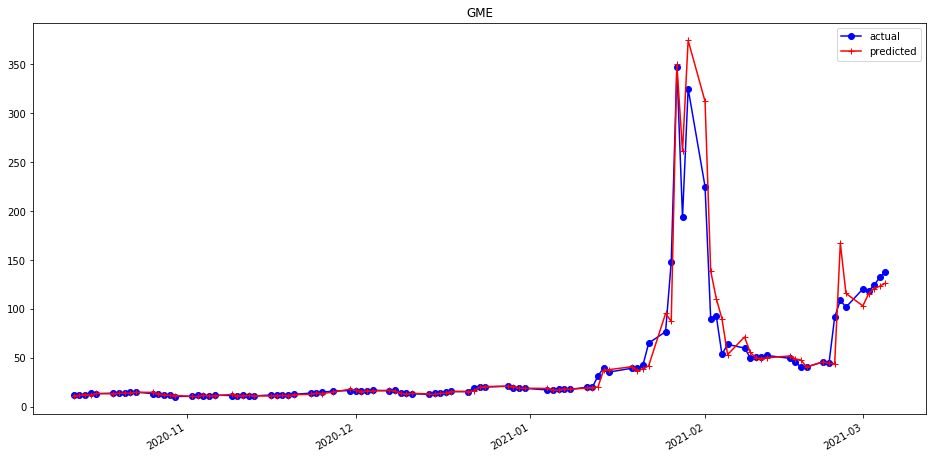

[11.493428421020509,
 11.56242812020438,
 12.489000075204032,
 11.818714060102192,
 13.573286165509906,
 13.247999586377826,
 13.829571165357319,
 13.701428195408413,
 13.997142669132778,
 14.83500018801008,
 14.716714586530413,
 13.514142894744873,
 12.094714736938478,
 11.710285827091763,
 11.473714624132429,
 10.665428270612445,
 10.596428571428572,
 11.592000225612097,
 11.109000451224192,
 11.355429022652762,
 12.577714511326382,
 11.335714285714285,
 11.335714285714285,
 11.57228548867362,
 11.197713947296144,
 11.000571278163365,
 11.48357105255127,
 11.631428759438652,
 11.434286090305873,
 12.370714473724366,
 12.715713909694127,
 14.026713834490096,
 13.405714661734445,
 15.071571390969414,
 17.910428646632603,
 16.865572030203683,
 15.475714097704207,
 16.244570977347237,
 16.06714210510254,
 16.75714285714286,
 16.136143684387207,
 13.72114293234689,
 12.932571315765381,
 13.71128556387765,
 13.149428721836635,
 12.597428308214461,
 13.760571466173445,
 13.760571466173445,


In [12]:
stock_predictor.predict_close_prices_for_days(100, with_plot=True)